In [9]:
import os
import glob
from helper import *
import time
import matplotlib.image as mpimg
from skimage.feature import hog
import numpy.random as random
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
import pickle

## Read Data

In [2]:
# read all traing and testing files
car_images = []
vehicle_dir = os.listdir("../vehicles/")
del vehicle_dir[0]
for path_dir in vehicle_dir:
    car_images.extend(glob.glob('../vehicles/'+ path_dir +'/*.png'))
    
not_car_images = []
non_vehicle_dir = os.listdir("../non-vehicles/")
del non_vehicle_dir[0]
for path_dir in non_vehicle_dir:
    not_car_images.extend(glob.glob('../non-vehicles/'+ path_dir +'/*.png'))

cars = []
notcars = []

for image in car_images:
    cars.append(image)
for image in not_car_images:
    notcars.append(image)
    
print("Number of cars is {}".format(len(cars)))
print("Number of not cars is {}".format(len(notcars)))

Number of cars is 8792
Number of not cars is 8968


## Extract Features

In [4]:
# extrack features
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(16, 16)
hist_bins=32,

t=time.time()
car_features = extract_features(cars, spatial_size=spatial_size,
                        hist_bins=hist_bins, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars,spatial_size=spatial_size,
                        hist_bins=hist_bins,color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

98.07 Seconds to extract HOG features...


## Examples

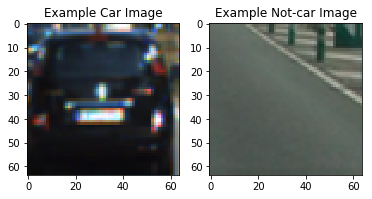

In [5]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

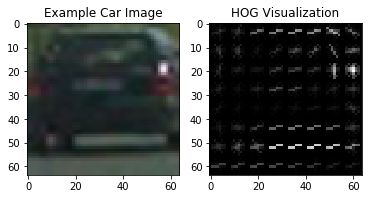

In [13]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        show=True, feature_vec=False)
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## Training Model

In [7]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6060
31.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.
  1.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.
  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.]
For these 100 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.
  1.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.
  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  1.  0.  1.  1.  0.

## Save Model

In [10]:
pickle_file = 'classifier.p'
print('Saving data to pickle file...')
with open(pickle_file, 'wb') as pfile:
    pickle.dump(
        {   'svc':svc, 
            'X_scaler': X_scaler,
            'color_space': colorspace,
            'spatial_size': spatial_size,
            'hist_bins': hist_bins,
            'orient': orient,
            'pix_per_cell': pix_per_cell,
            'cell_per_block': cell_per_block,
            'hog_channel': hog_channel,
#             'spatial_feat': spatial_feat,
#             'hist_feat': hist_feat,
#             'hog_feat':hog_feat
        },
        pfile, pickle.HIGHEST_PROTOCOL)
print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.
